# Kuramoto Order And Steady States

In [1]:
%run "../HyperParameterOpt/GenerateExperiments/res_experiment.py"
import copy
from matplotlib import pyplot as plt
import scipy as sp
from scipy import signal
DIFF_EQ_PARAMS = {
                  "x0": [-20, 10, -.5],
                  "begin": 0,
                  "end": 85,
                  "timesteps": 85000,
                  "train_per": .889,
                  "solver": lorenz_equ,
                  "clip": 40
                 }

RES_PARAMS = {
              "uniform_weights": True,
              "solver": "ridge",
              "ridge_alpha": 1e-6,
              "signal_dim": 3,
              "network": "random graph",

              "res_sz": 2500,
              "activ_f": np.tanh,
              "connect_p": .1,
              "spect_rad": 5,
              "gamma": 5,
              "sigma": .14,
              "sparse_res": True,
             }

TOL = 5
plt.rcParams["figure.figsize"] = [10, 5]

ImportError: cannot import name 'specialize' from 'rescomp' (/Users/djpassey/Code/rescomp/rescomp/__init__.py)

NameError: name 'lorenz_equ' is not defined

In [ ]:
def adj_matrix(topology, topo_params, n, remove_p=0):
    adj = generate_adj(topology, topo_params, n)
    adj = remove_edges(adj, floor(remove_p*np.sum(adj != 0)))
    return adj

def mean_driven_state(A):
    DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
    train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
    rc = ResComp(A, **RES_PARAMS)
    states = rc.drive(train_t, u)
    mean_node_state = np.mean(states, axis=1)
    return mean_node_state

def node_fft(node_state):
    N = len(node_state)
    nodef = np.abs(sp.fft.fft(node_state))
    freq = np.arange(N)/40
    # The frequencies are symmetric. We take half and multiply by 2
    nodef = 2*nodef[:N//2] 
    freq = freq[:N//2]
    return freq, nodef

In [5]:
def kuramoto_order(peaktimes, t):
    """ Compute the kuramoto order parameter of a system of oscilators.
        Parameters:
        ----------
        peaktimes (list): A list of length N > 1 where each entry is an array of 
                          oscilator peak times (use scipy.signal.find_peaks_cwt)
        t (ndarry): Time values where the order parameter should be computed
        Returns
        -------
        R (ndarray): kuramoto order parameter for each of the timesteps in t
    """
    R = np.zeros(len(t), np.complex)
    timemask = np.argsort(t)
    for peaks in peaktimes:
        prevpeak = peaks[1]
        prevprevpeak = peaks[0]
        j = 2
        for i, ti in enumerate(t[timemask]):
            if j >= len(peaks) - 1: break
            # Find first t value that occurs after the first peak
            if ti < prevpeak:
                pass
            # Find the first peak that is greater than the time value
            if ti >= peaks[j]:
                prevprevpeak = prevpeak
                prevpeak = peaks[j]
                j += 1
            # Compute kuramoto order
            if (ti >= prevpeak) and (ti < peaks[j]):
                phi = 2 * np.pi *(ti - prevpeak) / (prevpeak - prevprevpeak)
                R[i] += np.exp(1j*phi)
    R = np.abs(R) / len(peaktimes)
    return R

def state_peaks(t, states):
    peaks = []
    for i in range(states.shape[1]):
        peakidx = sp.signal.find_peaks(states[:,i].T)[0]
        peaktimes = t[peakidx]
        peaks.append(peaktimes)
    return peaks

In [6]:
def rc_kuramoto_ord(topo, topo_p=4, remove_p=0.0):
    DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
    train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
    A = adj_matrix(topo, topo_p, 2500, remove_p=remove_p)
    rc = ResComp(A, **RES_PARAMS)
    states = rc.drive(train_t, u)
    t = np.arange(len(states)) / 1000.0
    mask = np.abs(np.mean(states, axis=0)) > .97
    print("Number of steady states: ", np.sum(mask))
    peaks = state_peaks(t, states[:, ~mask])
    ko = kuramoto_order(peaks, t)
    print("Mean Kuramoto Order: ", np.mean(ko))
    return ko


# Kuramoto Order Parameter Measures the Degree of Phase Locking
Kuramoto Order is between 0 and 1. It is equal to:
$$
R(t) = \frac{1}{N}|\sum_{j}^{N}e^{i\phi_j(t)}|
$$
where $N$ is the number of signals and
$$
\phi_j(t) = 2\pi\frac{t - t_n}{t_{n} - t_{n-1}}
$$
with $t_n$ the time of most recent peak and $t_{n-1}$ the peak before $t_n$ (For signal $j$ at time $t$). 

In the plots below, R(t) is zero at the beginning and end because it needs at least two peaks.

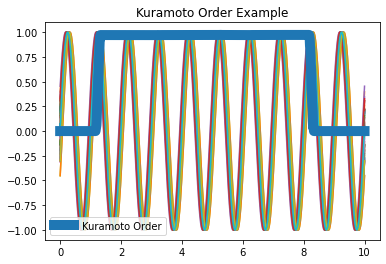

In [7]:
shiftsize = .3
times = np.linspace(0, 10, 1000)
N = 50
shiftsine = lambda : np.sin(2*np.pi*times + shiftsize*np.pi*(np.random.rand() - 0.5))
sines = [shiftsine() for i in range(N)]
peaksidx = [sp.signal.find_peaks(s)[0] for s in sines]
peaktimes = [times[p_i] for p_i in peaksidx]
ko = kuramoto_order(peaktimes, times)
for i in range(N):
    plt.plot(times, sines[i])
plt.plot(times, ko, lw=10, label="Kuramoto Order")
plt.title("Kuramoto Order Example")
plt.legend(loc="lower left")
plt.show()

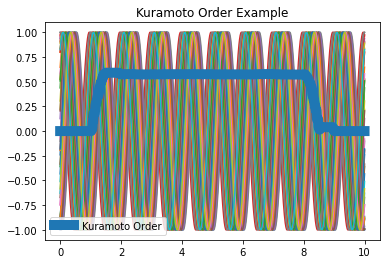

In [8]:
shiftsize = 1.2
times = np.linspace(0, 10, 1000)
N = 50
shiftsine = lambda : np.sin(2*np.pi*times + shiftsize*np.pi*(np.random.rand() - 0.5))
sines = [shiftsine() for i in range(N)]
peaksidx = [sp.signal.find_peaks(s)[0] for s in sines]
peaktimes = [times[p_i] for p_i in peaksidx]
ko = kuramoto_order(peaktimes, times)
for i in range(N):
    plt.plot(times, sines[i])
plt.plot(times, ko, lw=10, label="Kuramoto Order")
plt.title("Kuramoto Order Example")
plt.legend(loc="lower left")
plt.show()

## Reservoir Computer States

In [9]:
DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
A = adj_matrix("watts4", 0.1, 2500, remove_p=0.0)
rc = ResComp(A, **RES_PARAMS)
states = rc.drive(train_t, u)
t = np.arange(len(states)) / 1000.0

NameError: name 'random_lorenz_x0' is not defined

### We find which nodes go into a steady state
We say a node is in a steady state if the absolute value of the mean of it's orbit is greater than 0.97. More that 90% of nodes in the reservoir computer below are in this *steady state*. 

In [10]:
ss = np.abs(np.mean(states, axis=0)) > .97
plt.plot(states[2000:, ss])
plt.title(f"Watts Topology Steady States ({np.sum(ss)})")
plt.show()

NameError: name 'states' is not defined

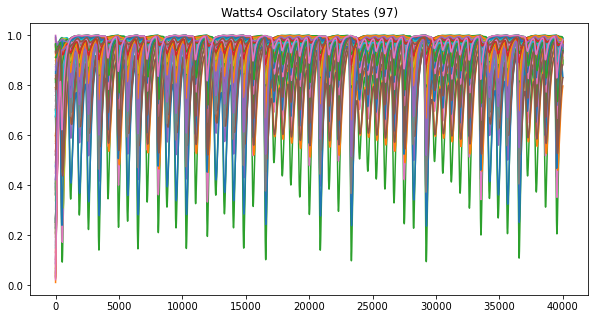

In [9]:
plt.plot(states[:, ~ss])
plt.title(f"Watts4 Oscilatory States ({np.sum(~ss)})")
plt.show()

## Steady States and Kuramoto Order Of Oscillatory States in Different Topologies
(Mean degree 4 unless specified)

## Watts (Remove 0%)

Number of steady states:  2408
Mean Kuramoto Order:  0.6089775235273265


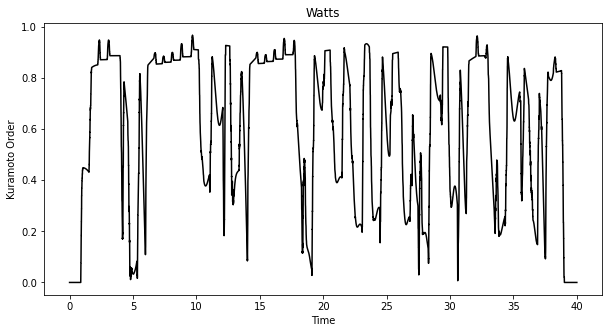

In [10]:
ko = rc_kuramoto_ord("watts4", topo_p=0.1, remove_p=0.0)
t = np.arange(len(states)) / 1000.0
plt.plot(t, ko, c='k')
plt.title("Watts")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Watts (Remove 90%)
BIG decrease in steady states!

Number of steady states:  319
Mean Kuramoto Order:  0.2013721677690215


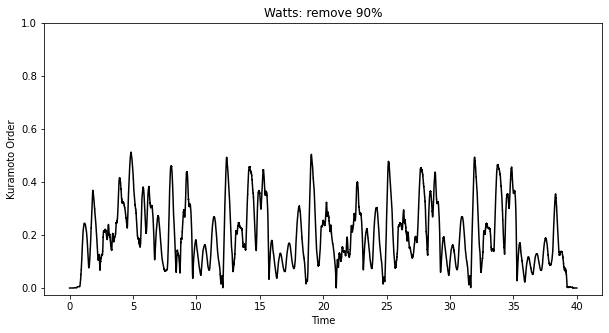

In [11]:
ko = rc_kuramoto_ord("watts4", topo_p=0.1, remove_p=0.9)
plt.plot(t, ko, c='k')
plt.title("Watts: remove 90%")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Geometric (Remove 0%)

Number of steady states:  829
Mean Kuramoto Order:  0.28307280469461904


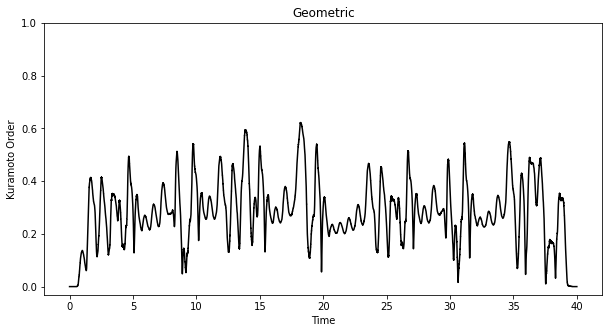

In [12]:
ko = rc_kuramoto_ord("geom", topo_p=4, remove_p=0.0)
plt.plot(t, ko, c='k')
plt.title("Geometric")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Geometric (Remove 90%)

Number of steady states:  311
Mean Kuramoto Order:  0.21204865045529034


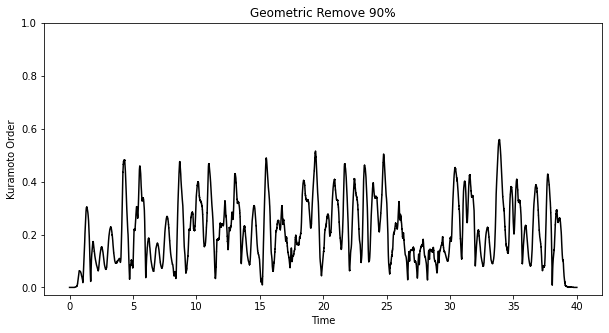

In [13]:
ko = rc_kuramoto_ord("geom", topo_p=4.0, remove_p=0.9)
plt.plot(t, ko, c='k')
plt.title("Geometric Remove 90%")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Identity (Remove 0%)

Number of steady states:  2484
Mean Kuramoto Order:  0.6034555598231712


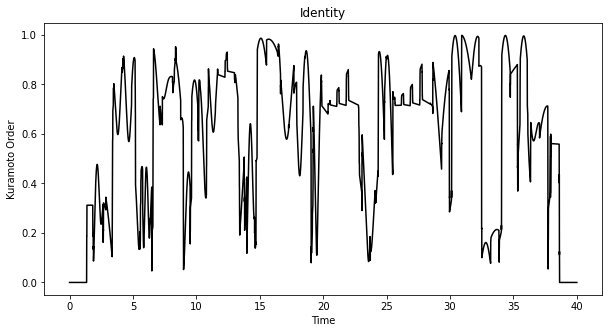

In [14]:
ko = rc_kuramoto_ord("ident", topo_p=None, remove_p=0.0)
plt.plot(t, ko, c='k')
plt.title("Identity")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Identity (Remove 90%)

In [15]:
ko = rc_kuramoto_ord("ident", topo_p=None, remove_p=0.9)
plt.plot(t, ko, c='k')
plt.title("Identity Remove 90%")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

Number of steady states:  248


KeyboardInterrupt: 

## Zero Matrix (Remove 0%)

In [ ]:
ko = rc_kuramoto_ord("ident", topo_p=None, remove_p=1.0)
plt.plot(t, ko, c='k')
plt.title("Zero Matrix")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Barabasi (Remove 0%)

In [ ]:
ko = rc_kuramoto_ord("barab2", topo_p=None, remove_p=0.0)
plt.plot(t, ko, c='k')
plt.title("Barabasi (degree 2)")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Barabasi (Remove 90%)

In [ ]:
ko = rc_kuramoto_ord("barab2", topo_p=None, remove_p=0.9)
plt.plot(t, ko, c='k')
plt.title("Barabasi (degree 2) remove 90%")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Random Digraph (Remove 0%)

In [ ]:
ko = rc_kuramoto_ord("random_digraph", topo_p=4.0, remove_p=0.0)
plt.plot(t, ko, c='k')
plt.title("Random Digraph")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Random Digraph (Remove 90%)

In [ ]:
ko = rc_kuramoto_ord("random_digraph", topo_p=4.0, remove_p=0.9)
plt.plot(t, ko, c='k')
plt.title("Random Digraph remove 90%")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Erdos (Remove 0%)

In [ ]:
ko = rc_kuramoto_ord("erdos", topo_p=4.0, remove_p=0.0)
plt.plot(t, ko, c='k')
plt.title("Erdos")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Erdos (Remove 90%)

In [ ]:
ko = rc_kuramoto_ord("erdos", topo_p=4.0, remove_p=0.9)
plt.plot(t, ko, c='k')
plt.title("Erdos remove 90%")
plt.xlabel("Time")
plt.ylabel("Kuramoto Order")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Discussion

**Steady States** 

As you probably noticed, the steady states in I plotted weren't actually steady. They also contain oscilations, and if you zoom in, not one if them is truly steady, it's just that the oscilations are very small. I only looked at the Kuramoto order parameter for the *non steady-state* nodes. When you compute the Kuramoto order for all nodes, every network has the same Kuramoto order (about 0.23). It is only when you separate out the steady states that you see a difference when the networks are thinned.

Another point is that I used a threshold to find the steady states, and this can be tuned.

**Hyper Parameters** 

We can't draw really strong conclusions here because the hyper parameters may affect phase locking and steady states. For instance, the identity matrix has a huge amount of phase locking before it is thinned, suggesting that it may not be local communities that cause phase locking and steady states. I would expect that since the identity matrix has so much phase locking, spectral radius would play a role (magnitude of entries on the diagonal).

**Ideas** 

There seems to be a strong link between having a lot of edges and having a lot of *steady states*, but the identity casts doubt on this because it has 1/4 as many connections as the other graphs (identity mean degree=1) but it has the most phase locking. Watts and geometric have strong local community structure, but watts exhibits a huge amount of steady states and phase locking whereas geometric does not.

It could be that the kuramoto order is higher when you have a smaller pool of nodes states to draw from, which would explain the higher phase locking of the identity and watts, since the kuramoto order was computed from the 200 or so non steady state nodes.

**Conclusion**

We have an apparent connection between topology and thinning now, one that appears to move in a direction we would expect. This could be a first for us—things working the way we expect. We'll have to decide what direction to take this, but it is pretty exciting. I am considering picking a few smart hyper parameter combinations (with Joey and Joseph's help) and getting the kuramoto order and steady states as well as prediction accuracy to see how they correlate.
